In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
import stockstats
from pandas_datareader import data as web
from stockstats import StockDataFrame as Sdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
import datetime
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2017,4,1)
end1 = datetime.datetime(2017,1,1)

In [191]:
df_AAPL = web.DataReader('FISV', 'yahoo', start, end)

In [192]:
def rsi(data):
    stock_df = Sdf.retype(data)
    data['rsi']=stock_df['rsi_14']
    return data

def EWMA(data, ndays):
    EMA = pd.Series(pd.ewma(data['close'], span = ndays, min_periods = ndays - 1), 
    name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

def signal(data):
    '''
    Signal=100 means BUY,
    Signal=-100 means SELL
    If previous BUY Signal is Already there then don't BUY
    If previous BUY Signal is there then only SELL
    '''
    data['Signal'] = 0

    data['Signal'][(data['EWMA_20'] > data['EWMA_50'])] = 100
    data['Signal'][data['Signal'].shift(1) ==100] = 75
    for i in range(len(data)):
        if (data['EWMA_20'][i] < data['EWMA_50'][i]) & (data['Signal'][i-1]==75):
            data['Signal'][i] = -100
    
    data['Transaction_price'] = 0
    
    data['Transaction_price'][(data['Signal']==100) | (data['Signal'] == -100)] = data['close']
    data['Transaction_price'][(data['Signal']==75)] = data['Transaction_price'].shift(1)
    for i in range(len(data)):
        if data['Signal'][i]==75:
            data['Transaction_price'][i]= data['Transaction_price'][i-1]
    #data['Transaction_price'][(data['Signal'].shift(1)==75) & (data['Signal']==75)] = data['Transaction_price'].shift(1)
            
    data = data.dropna()
    data['Returns'] = 0
    data['Returns'][data['Signal']==-100] = ((data['Transaction_price']/data['Transaction_price'].shift(1)) - 1)*100
    
    data['Cumm Returns'] = 0
    data['Cumm Returns'] = data['Returns'].cumsum()
    return data

In [193]:
df_AAPL = rsi(df_AAPL)

In [194]:
df_AAPL1 = EWMA(df_AAPL, 10)
df_AAPL1 = EWMA(df_AAPL1, 20)
df_AAPL1 = EWMA(df_AAPL1, 50)
df_AAPL1 = signal(df_AAPL1)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=9,adjust=True).mean()
  import sys
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=20,min_periods=19,adjust=True).mean()
  import sys
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=50,min_periods=49,adjust=True).mean()
  import sys
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [195]:
df_AAPL2 = df_AAPL1.dropna()

In [207]:
df_AAPL2.head()

,open,high,low,close,adj close,volume,close_-1_s,close_-1_d,rs_14,rsi_14,rsi,EWMA_10,EWMA_20,EWMA_50,Signal,Transaction_price,Returns,Cumm Returns
Date,,,,,,,,,,,,,,,,,,
2015-03-13,77.980003,78.230003,76.930000,77.400002,77.400002,1161400,78.239998,-0.839996,1.043143,51.055809,51.055809,77.747345,77.656577,76.799448,100,77.400002,0.0,0.0
2015-03-16,78.169998,78.750000,77.900002,78.669998,78.669998,1160900,77.400002,1.269996,1.398471,58.306775,58.306775,77.915108,77.753745,76.884281,75,77.400002,0.0,0.0
2015-03-17,78.320000,78.760002,78.320000,78.570000,78.570000,967300,78.669998,-0.099998,1.357567,57.583396,57.583396,78.034183,77.831958,76.960265,75,77.400002,0.0,0.0
2015-03-18,78.279999,80.169998,78.139999,79.839996,79.839996,1021400,78.570000,1.269996,1.757610,63.736715,63.736715,78.362523,78.024256,77.089313,75,77.400002,0.0,0.0
2015-03-19,79.970001,80.230003,79.650002,80.180000,80.180000,945300,79.839996,0.340004,1.872948,65.192550,65.192550,78.692981,78.230591,77.227044,75,77.400002,0.0,0.0


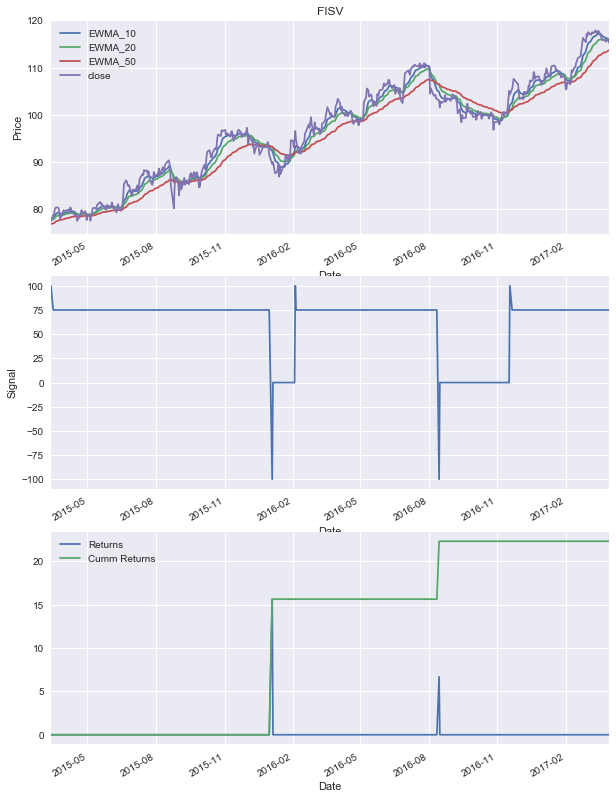

In [210]:
plt.figure(figsize=(10,20))
plt.subplot(411)
df_AAPL2['EWMA_10'].plot()
df_AAPL2['EWMA_20'].plot()
df_AAPL2['EWMA_50'].plot()
df_AAPL2['close'].plot()
plt.ylabel('Price')
plt.title('FISV')
plt.legend()

plt.subplot(412)
df_AAPL2['Signal'].plot()
plt.ylabel('Signal')

#plt.subplot(413)
#df_AAPL2['rsi_14'].plot()
#plt.ylabel('RSI')
#plt.axhline(y=70)
#plt.axhline(y=30)

plt.subplot(413)
df_AAPL2['Returns'].plot()
df_AAPL2['Cumm Returns'].plot()
plt.legend()